In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [ ]:
import torch
from torch import nn
import torchvision
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from pathlib import Path
dataset_path = Path("/content/animal-faces/afhq")
train_dir = dataset_path /"train"
val_dir = dataset_path / "val"
train_dir, val_dir

(PosixPath('/content/animal-faces/afhq/train'),
 PosixPath('/content/animal-faces/afhq/val'))

In [ ]:
#View some images
#get a list of the training images
os.listdir(train_dir)
list_of_training_data_images = list(Path(train_dir).glob("*/*.jpg"))
list_of_validation_data_images = list(Path(val_dir).glob("*/*.jpg"))
len(list_of_training_data_images), len(list_of_validation_data_images)

(14630, 1500)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

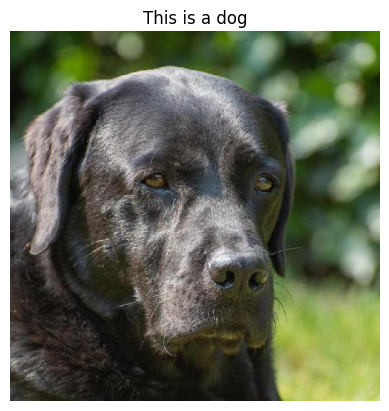

In [ ]:
import random
random_choice = random.choice(list_of_training_data_images)
random_image = Image.open(random_choice)
name_of_image = random_choice.parent.stem
plt.imshow(random_image)
plt.title(f"This is a {name_of_image}")
plt.axis(False)

In [ ]:
def class_names(list_path):
  return os.listdir(list_path)



In [ ]:
class_name = class_names(train_dir)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, root_dir, transform=None, label_encoder=None):
    self.root_dir = Path(root_dir)
    self.transform = transform

    #get all image file paths
    self.image_paths = list(self.root_dir.glob("*/*.jpg"))

    #extract labels from folder names
    self.labels = [p.parent.stem for p in self.image_paths]

    # Store the provided label encoder
    self.label_encoder = label_encoder

    self.class_to_idx = {}
    idx = 0
    for entry in os.scandir(root_dir):
      if entry.is_dir():
        self.class_to_idx[entry.name] = idx
        idx += 1


  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    class_name = self.labels[idx] # Original string label
    label = self.class_to_idx[class_name]
    image = Image.open(image_path).convert("RGB")
    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
#create transforms
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((288,288)),
    transforms.ToTensor(),
    transforms.transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor()
])

In [ ]:
#get train and val datasets
train_dataset = ImageDataset(root_dir = train_dir, transform = train_transform)
validation_dataset = ImageDataset(root_dir = val_dir, transform = val_transform)

In [ ]:
X,y = next(iter(train_dataset))


In [ ]:
#Create dataloaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size = 32,
                              shuffle = True,
                              num_workers=2)

val_dataloader = DataLoader(dataset=validation_dataset,
                              batch_size = 32,
                              num_workers=2)

In [ ]:
len(train_dataloader), len(val_dataloader)

(458, 47)

In [ ]:
#get your model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT


In [ ]:
weights.transforms()

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
model = torchvision.models.efficientnet_b2(weights=weights)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
for params in model.parameters():
  params.requires_grad=False

In [ ]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True ),
    nn.Linear(in_features=1408, out_features=3)
)

In [ ]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=1e-3)

In [ ]:
#create a training loop
from tqdm.auto import tqdm
EPOCH = 5
for epoch in tqdm(range(EPOCH)):
  model.train()

  train_loss, train_acc = 0 ,0
  for X,y in train_dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_prob = torch.softmax(y_pred, dim=1)
    y_pred_class = torch.argmax(y_pred_prob, dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss/len(train_dataloader)
  train_acc = train_acc/len(train_dataloader)

  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in val_dataloader:
      X, y = X.to(device), y.to(device) # Added this line to move validation data to device
      test_pred = model(X)

      loss = loss_fn(test_pred, y)

      test_loss += loss.item()

      test_acc += (test_pred.argmax(dim=1) == y).sum().item()/len(test_pred)

    test_loss /= len(val_dataloader)
    test_acc /= len(val_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss : {test_loss:.5f}, Test acc: {test_acc:.2f}\n")













  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from PIL import Image
def prediction_and_show(img,transform,model):
  #open image
  img = Image.open(img)
  #transform image
  transformed_img = transform(img).unsqueeze(0)
  #forward pass
  logits = model(transformed_img)
  pred_prob = torch.softmax(logits, dim=1)
  pred_label = torch.argmax(pred_prob, dim=1)
  pred_class = class_name[pred_label]

  picture = plt.imshow(img)
  title = plt.title(f"This is a {pred_class}")
  plt.axis(False)

  return title, picture

